In [149]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats
import math
from statsmodels.stats.outliers_influence import summary_table
from backtesting import Backtest, Strategy
from backtesting.lib import crossover,SignalStrategy

from backtesting.test import SMA, GOOG
import collections

In [3]:
da=pd.read_csv('^HSI.csv',sep=',')

In [143]:
da.Date=pd.to_datetime(da.Date,format='%d/%m/%Y')
da['clr'] = np.log(da.Close / da.Close.shift(1))
close_log_return = da['clr'].dropna()
da.head()

,Date,Open,High,Low,Close,Volume,clr
0,1990-01-02,2836.0,2851.0,2798.0,2838.100098,0,NaN
1,1990-01-03,2836.0,2873.0,2836.0,2858.699951,0,0.007232
2,1990-01-04,2858.0,2876.0,2850.0,2868.000000,0,0.003248
3,1990-01-05,2867.0,2875.0,2838.0,2839.899902,0,-0.009846
4,1990-01-08,2839.0,2839.0,2815.0,2816.000000,0,-0.008451


In [5]:
print(da['clr'].skew())
print(da['clr'].kurtosis())

-0.020928099454319945
9.683541591601564


# HSI is negatively skewed with thicker tails than normal, thus we want to look for upside potential and rare opportunities.

/Users/nick/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


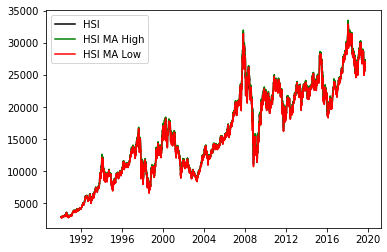

In [6]:
rolling_high = da.High.rolling(window=30).mean()
rolling_low = da.Low.rolling(window=30).mean()
plt.plot(da.Date, da.Close, label='HSI',color='black')
plt.plot(da.Date, da.High, label='HSI MA High', color='green')
plt.plot(da.Date, da.Low, label='HSI MA Low', color='red')
plt.legend(loc='upper left')
plt.show()

In [142]:
signals = pd.DataFrame(index=da.index)
signals['signal1'] = 0
signals['signal2'] = 0
signals['buysignal1']=0
signals['sellsignal1']=0
signals['buysignal2']=0
signals['sellsignal2']=0
signals['close'] = da.Close
# Create the set of  moving averages over 30 days
signals['high_mavg'] = da.High.rolling(window=30).mean()
signals['low_mavg'] = da.Low.rolling(window=30).mean()
signals['high_max'] = da.High.rolling(window=29).max().shift()
signals['low_min'] = da.Low.rolling(window=29).min().shift()

# series results in +1, 0, and -1 values. In our signal,
# as expected by SignalStrategy, +1 means buy,
# -1 means sell, and 0 means to hold whatever current
# position and wait.

#cross channel
signals['sellsignal1'][29:] = np.where(signals['low_mavg'][29:] > pd.Series(da.Close)[29:], 1, 0)   
signals['buysignal1'][29:] = np.where(signals['high_mavg'][29:] < pd.Series(da.Close)[29:], 1, 0)  
signals['signal1'][29:] =signals['buysignal1'][29:]-signals['sellsignal1'][29:]

#cross channel and over past 30 days Max(high) or below past 30 days Min(low)
signals['sellsignal2'][29:] = np.where((signals['low_mavg'][29:] > pd.Series(da.Close)[29:])&(signals['low_min'][29:] > pd.Series(da.Close)[29:]),1,0)
signals['buysignal2'][29:] = np.where((signals['high_mavg'][29:] < pd.Series(da.Close)[29:])&(signals['high_max'][29:] < pd.Series(da.Close)[29:]),1,0) 
signals['signal2'][29:] =signals['buysignal2'][29:]-signals['sellsignal2'][29:]

#replace consecutive repeated signals to 0
signals['signal2_v2'] =(signals['signal2'] != signals['signal2'].shift(1)).astype('int')*signals['signal2']
signals['signal1_v2'] =(signals['signal1'] != signals['signal1'].shift(1)).astype('int')*signals['signal1']
signals[25:100]

/Users/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set o

,signal1,signal2,buysignal1,sellsignal1,buysignal2,sellsignal2,close,high_mavg,low_mavg,high_max,low_min,signal2_v2,signal1_v2
25,0,0,0,0,0,0,2903.800049,NaN,NaN,NaN,NaN,0,0
26,0,0,0,0,0,0,2893.899902,NaN,NaN,NaN,NaN,0,0
27,0,0,0,0,0,0,2894.699951,NaN,NaN,NaN,NaN,0,0
28,0,0,0,0,0,0,2863.600098,NaN,NaN,NaN,NaN,0,0
29,1,0,1,0,0,0,2870.399902,2824.993335,2792.933333,2912.0,2697.0,0,1
30,1,0,1,0,0,0,2910.000000,2826.960002,2795.333333,2912.0,2697.0,0,0
31,1,1,1,0,1,0,2939.300049,2829.826668,2797.866667,2912.0,2697.0,1,0
32,1,1,1,0,1,0,2968.000000,2832.893335,2800.866667,2959.0,2697.0,0,0
33,1,1,1,0,1,0,2980.000000,2836.460002,2804.900000,2968.0,2697.0,0,0
34,1,0,1,0,0,0,2862.300049,2840.960002,2806.466667,2982.0,2697.0,0,0


In [150]:
collections.Counter(signals['signal2_v2'])

Counter({0: 6741, 1: 386, -1: 222})

In [151]:
collections.Counter(signals['signal1_v2'])

Counter({0: 6742, 1: 317, -1: 290})

# channel strategy

In [157]:
class channel(SignalStrategy):
    def init(self):
        self.set_signal(signals.signal1_v2)

In [153]:
# class channel1(SignalStrategy):
#     def init(self):
#         self.set_signal(signals.signal2_v2)
        
# class channel(SignalStrategy):
#     def init(self):
#         High = self.data.High
#         Low = self.data.Low
#         Close = self.data.Close
#         self.mahigh = self.I(SMA, High, 30)
#         self.malow = self.I(SMA, Low, 30)
#         self.Close=Close
        
#         # series results in +1, 0, and -1 values. In our signal,
#         # as expected by SignalStrategy, +1 means buy,
#         # -1 means sell, and 0 means to hold whatever current
#         # position and wait.
#         signal1 = (pd.Series(self.Close) < self.malow).astype(int).fillna(0)
#         signal2 = 1*(pd.Series(self.Close) > self.mahigh).astype(int).fillna(0)
#         signal=signal2-signal1
#         self.set_signal(signal)

In [158]:
bt = Backtest(da, channel,cash=10000, commission=0)
print(bt.run())
bt.plot()


/Users/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Data index is not datetime. Assuming simple periods.
  """Entry point for launching an IPython kernel.


Start                              0
End                             7348
Duration                        7348
Exposure [%]                 99.5645
Equity Final [$]             44608.5
Equity Peak [$]              64741.4
Return [%]                   346.085
Buy & Hold Return [%]        819.357
Max. Drawdown [%]           -56.2968
Avg. Drawdown [%]           -7.95872
Max. Drawdown Duration          1460
Avg. Drawdown Duration       84.0179
# Trades                         606
Win Rate [%]                 41.7492
Best Trade [%]               35.4584
Worst Trade [%]             -15.5256
Avg. Trade [%]              0.356143
Max. Trade Duration               76
Avg. Trade Duration          12.0726
Expectancy [%]               3.14829
SQN                          1.02519
Sharpe Ratio               0.0685459
Sortino Ratio               0.187014
Calmar Ratio              0.00632617
_strategy                    channel
dtype: object


# golden/deadth cross

In [165]:
class SmaCross(Strategy):
    def init(self):
        High = self.data.High
        Low = self.data.Low
        Close = self.data.Close
        self.sma = self.I(SMA, Close, 10)
        self.lma = self.I(SMA, Close, 30)
        self.Close=Close

    def next(self):
        if crossover(self.sma, self.lma) :
            self.buy()
        elif crossover(self.lma,self.sma):
            self.sell()

In [166]:
bt = Backtest(da, SmaCross,cash=10000, commission=0)
bt.run()

/Users/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Data index is not datetime. Assuming simple periods.
  """Entry point for launching an IPython kernel.


Start                              0
End                             7348
Duration                        7348
Exposure [%]                 99.1018
Equity Final [$]             16894.9
Equity Peak [$]              38334.3
Return [%]                   68.9487
Buy & Hold Return [%]        819.357
Max. Drawdown [%]            -62.453
Avg. Drawdown [%]            -7.1651
Max. Drawdown Duration           940
Avg. Drawdown Duration       89.2941
# Trades                         265
Win Rate [%]                 39.2453
Best Trade [%]               30.8793
Worst Trade [%]             -14.8608
Avg. Trade [%]              0.429974
Max. Trade Duration              101
Avg. Trade Duration          27.4792
Expectancy [%]               5.01879
SQN                         0.346316
Sharpe Ratio               0.0606151
Sortino Ratio               0.166009
Calmar Ratio              0.00688476
_strategy                   SmaCross
dtype: object

In [167]:
bt.plot()